In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax.config import config

config.update("jax_debug_nans", True)

In [3]:
from ais import UnadjustedLangevin
import equinox as eqx
import optax
import jax
import jax.numpy as jnp
from jax.random import PRNGKey, split
import matplotlib.pyplot as plt
import numpyro.distributions as dist
from tqdm.auto import trange

In [4]:
x_dim = 1
T = 10.0
pi_0 = dist.Normal(jnp.zeros((x_dim,))).to_event(1)
n_components = 3
means = dist.Normal(jnp.zeros((x_dim,)), 3.0).sample(PRNGKey(43), (n_components,))
stdev = 1.0


def _get_component_log_prob(x, mean, stdev):
    return dist.Normal(mean, stdev).log_prob(x)


def get_log_gamma(x):
    log_probs = jax.vmap(lambda mean: _get_component_log_prob(x, mean, stdev))(means)
    return jnp.log(jnp.exp(log_probs).sum() / len(log_probs))


def get_log_pi(t, x):
    return (1 - t / T) * pi_0.log_prob(x) + t / T * get_log_gamma(x)


get_score_pi = jax.grad(get_log_pi, argnums=1)

In [29]:
def get_binned_ys(xs, bins, ys):
    """
    Bins y values based on their corresponding x values
    """
    binned_ys = []
    for left, right in zip(bins[:-1], bins[1:]):
        idxs = (xs[:, -1] >= left) & (xs[:, -1] < right)
        binned_ys.append(ys[idxs])
    return binned_ys

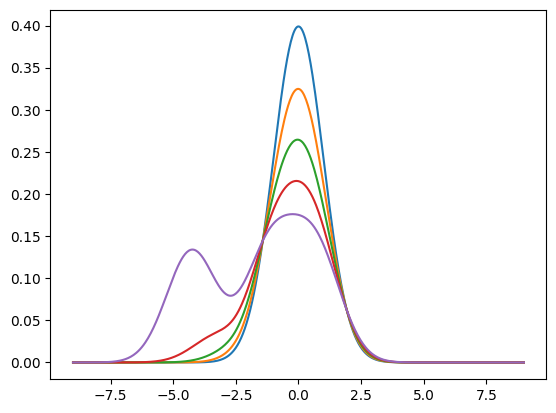

In [5]:
x_grid = jnp.linspace(-9, 9, 500)
for r in [0, 0.25, 0.5, 0.75, 1.0]:
    plt.plot(x_grid, jnp.exp(jax.vmap(lambda x: get_log_pi(r * T, x))(x_grid)))

In [25]:
from typing import Callable, List
from jaxtyping import Array


class ResBlock(eqx.Module):
    layer_norm: eqx.nn.LayerNorm
    t_linear: eqx.nn.Linear
    h_linear: eqx.nn.Linear
    final_linear: eqx.nn.Linear
    activation: Callable[[Array], Array] = eqx.static_field()

    def __init__(self, t_dim, h_dim, activation=jax.nn.swish, out_dim=None, *, key):
        super().__init__()
        key_t, key_h, key_final = split(key, 3)
        self.layer_norm = eqx.nn.LayerNorm(h_dim)
        self.t_linear = eqx.nn.Linear(t_dim, 2 * h_dim, key=key_t)
        self.h_linear = eqx.nn.Linear(h_dim, 2 * h_dim, key=key_h)
        if out_dim is None:
            out_dim = h_dim
        self.final_linear = eqx.nn.Linear(2 * h_dim, out_dim, key=key_final)
        self.activation = activation

    def __call__(self, t, h):
        t_emb = self.t_linear(t)
        h = self.layer_norm(h)
        h = self.activation(h)
        h = self.h_linear(h)
        h = t_emb + h
        h = self.activation(h)
        h = self.final_linear(h)
        return h


class Model(eqx.Module):
    t_scale: float = eqx.static_field()
    t_linear: eqx.nn.Linear
    x_linear: eqx.nn.Linear
    res_blocks: List[ResBlock]
    final_scale: Array

    def __init__(
        self,
        x_dim,
        t_dim,
        h_dim,
        depth,
        t_scale,
        get_score_pi,
        activation=jax.nn.swish,
        *,
        key
    ):
        super().__init__()
        self.t_scale = t_scale

        key_t, key_x, key_res, key_final = split(key, 4)
        self.t_linear = eqx.nn.Linear(1, t_dim, key=key_t)
        self.x_linear = eqx.nn.Linear(x_dim, h_dim, key=key_x)
        self.res_blocks = [
            ResBlock(t_dim, h_dim, activation, key=key)
            for key in split(key_res, depth - 1)
        ]
        self.res_blocks.append(ResBlock(t_dim, h_dim, activation, x_dim, key=key_final))
        self.final_scale = jnp.zeros(1)

    def __call__(self, t, x):
        t_emb = self.t_linear(jnp.atleast_1d(t) * self.t_scale)
        h = self.x_linear(x)
        for res_block in self.res_blocks:
            h = res_block(t_emb, h)
        return self.final_scale * h + get_score_pi(t, x)

In [26]:
key = PRNGKey(87)

n_timesteps = 64
ula = UnadjustedLangevin(pi_0, get_log_gamma, get_score_pi, n_timesteps, T)

key, subkey = split(key)
t_dim = 4
h_dim = 128
depth = 3
model = Model(x_dim, t_dim, h_dim, depth, ula.delta, get_score_pi, key=subkey)
lr = 5e-3
optim = optax.adam(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))  # type: ignore
batch_size = 256


@eqx.filter_jit
def train_step(model, key, opt_state, batch_size):
    keys = split(key, batch_size)
    get_loss = lambda model, keys: jax.vmap(ula.get_loss, (None, 0))(model, keys).sum()
    loss, grads = eqx.filter_value_and_grad(get_loss)(model, keys)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state


n_steps = 200
batch_size = 512
losses = []
with trange(n_steps) as pbar:
    for _ in pbar:
        key, subkey = split(key)
        loss, model, opt_state = train_step(model, subkey, opt_state, batch_size)
        losses.append(loss.item())
        pbar.set_postfix(loss=losses[-1])

losses = jnp.array(losses)

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0, 0.5, 'Epoch')

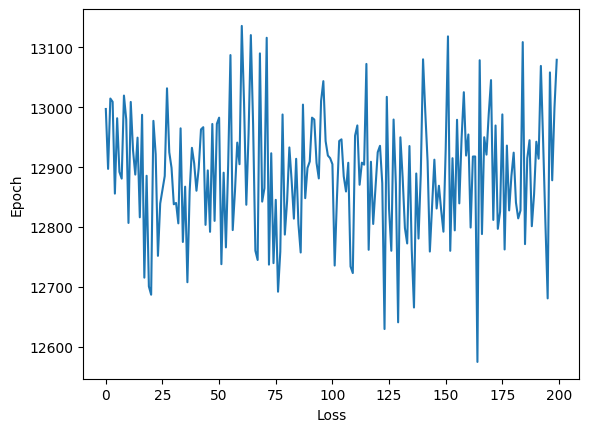

In [36]:
plt.plot(losses)
plt.xlabel("Loss")
plt.ylabel("Epoch")

In [37]:
# Get samples
key, subkey = split(key)
n_samples = 40_000
xs_mcd, log_ws_mcd = jax.jit(jax.vmap(ula.get_trajectory_mcd, (None, 0)))(model, split(subkey, n_samples))
xs_mcd = xs_mcd[..., 0]

key, subkey = split(key)
n_samples = 40_000
xs_ais, log_ws_ais = jax.jit(jax.vmap(ula.get_trajectory_ais))(split(subkey, n_samples))
xs_ais = xs_ais[..., 0]

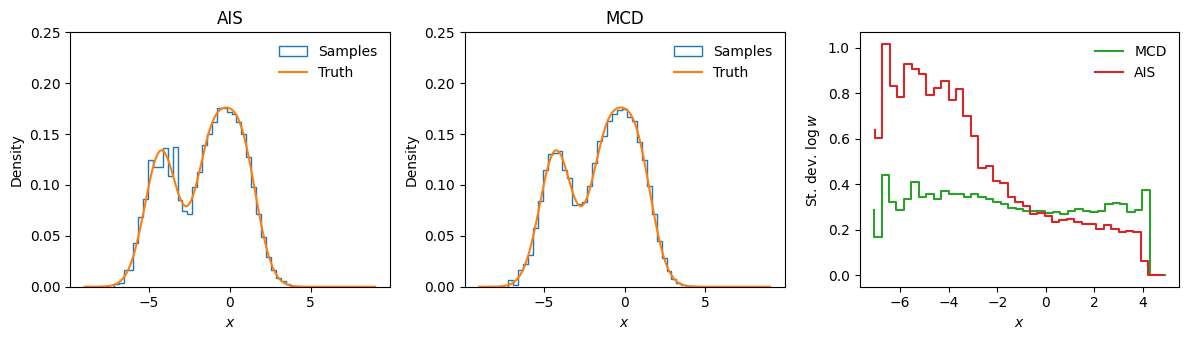

In [30]:
plt.figure(figsize=(12, 3.5))

plt.subplot(1, 3, 1)
_, x_bins_ais, _ = plt.hist(
    xs_ais[:, -1],
    bins=40,
    weights=jnp.exp(log_ws_ais),
    density=True,
    histtype="step",
    label="Samples",
)
x_grid = jnp.linspace(-9, 9, 500)
plt.plot(x_grid, jnp.exp(jax.vmap(get_log_gamma)(x_grid)), label="Truth")
plt.xlabel(r"$x$")
plt.ylabel("Density")
plt.ylim(0, 0.25)
plt.title("AIS")
plt.legend(frameon=False)

plt.subplot(1, 3, 2)
_, x_bins_mcd, _ = plt.hist(
    xs_mcd[:, -1],
    bins=40,
    weights=jnp.exp(log_ws_mcd),
    density=True,
    histtype="step",
    label="Samples",
)
x_grid = jnp.linspace(-9, 9, 500)
plt.plot(x_grid, jnp.exp(jax.vmap(get_log_gamma)(x_grid)), label="Truth")
plt.xlabel(r"$x$")
plt.ylabel("Density")
plt.ylim(0, 0.25)
plt.title("MCD")
plt.legend(frameon=False)

plt.subplot(1, 3, 3)
# MCD
binned_log_ws_mcd = get_binned_ys(xs_mcd, x_bins_mcd, log_ws_mcd)
log_w_vars_mcd = jnp.array(
    [jnp.std(lw) if len(lw) > 0 else 0.0 for lw in binned_log_ws_mcd]
)
plt.step(
    0.5 * (x_bins_mcd[1:] + x_bins_mcd[:-1]), log_w_vars_mcd, label="MCD", color="C2"
)
# AIS
binned_log_ws_ais = get_binned_ys(xs_ais, x_bins_ais, log_ws_ais)
log_w_vars_ais = jnp.array(
    [jnp.std(lw) if len(lw) > 0 else 0.0 for lw in binned_log_ws_ais]
)
plt.step(
    0.5 * (x_bins_ais[1:] + x_bins_ais[:-1]), log_w_vars_ais, label="AIS", color="C3"
)
plt.xlabel(r"$x$")
plt.ylabel(r"St. dev. $\log w$")
plt.legend(frameon=False)

plt.tight_layout()

Text(0.5, 1.0, 'Histogram of trajectories')

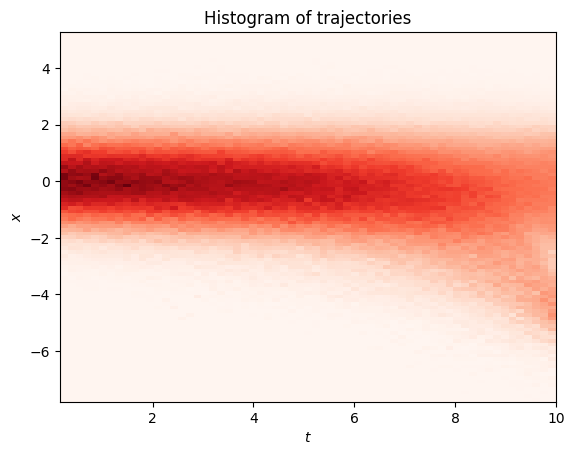

In [35]:
plt.hist2d(
    jnp.tile((jnp.linspace(ula.delta, ula.T, ula.n_timesteps - 1)), len(xs_mcd)),
    xs_mcd.flatten(),
    bins=(ula.n_timesteps - 1, 100),
    cmap="Reds",
    weights=jnp.array((ula.n_timesteps - 1) * (jnp.exp(log_ws_mcd),)).T.flatten(),
)
plt.gca().set_aspect("auto")
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.title("Histogram of trajectories")